In [1]:
import seaborn as sns



import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
import category_encoders as ce

In [2]:
df = pd.read_csv('gun-violence-data.csv')

## Plot two encoding approaches

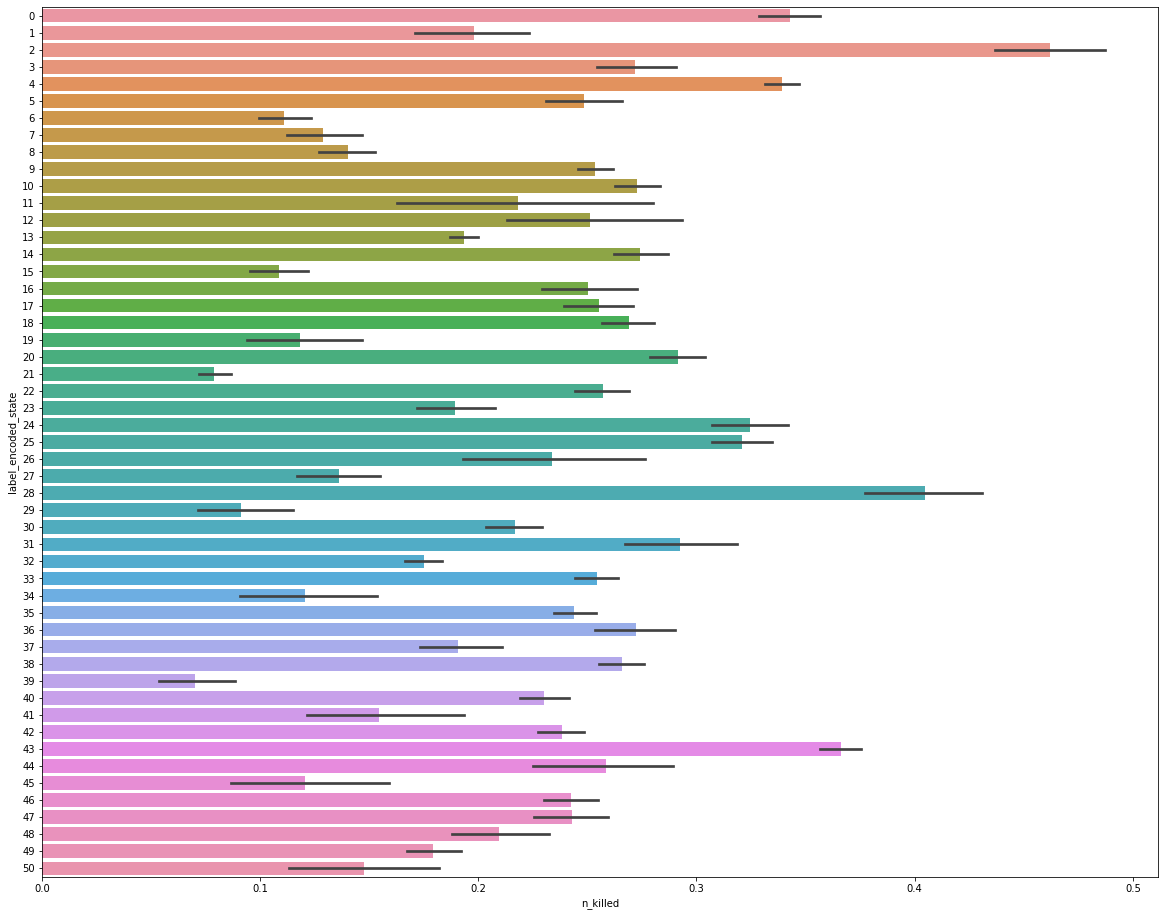

In [3]:
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (20, 16)

df['label_encoded_state'] = LabelEncoder().fit_transform(df['state'])
sns.barplot(y='label_encoded_state', x='n_killed', data=df, orient='h')


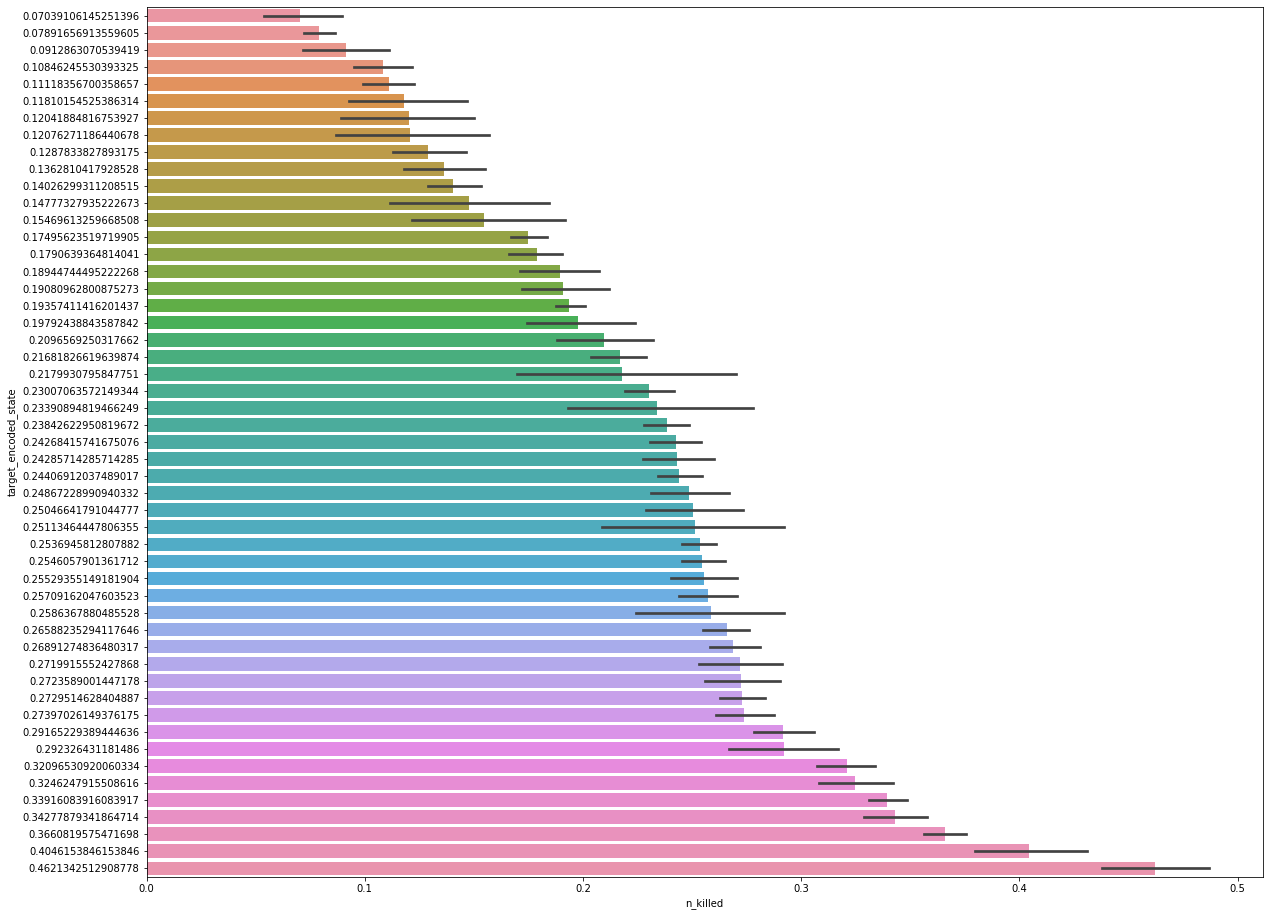

In [4]:
encoder = ce.TargetEncoder()
encoder.fit(df['state'], df['n_killed'])
df['target_encoded_state'] = encoder.transform(df['state'])
sns.barplot(y='target_encoded_state', x='n_killed', data=df, orient='h')

## Collect categorical features

In [5]:
categorical_columns = [
    "state",
    "city_or_county",
    "gun_stolen",
    "gun_type",
    "participant_age_group",
    "participant_gender",
    "participant_relationship",
    "participant_status",
    "participant_type"
]

In [6]:
for c in categorical_columns:
    print(c, len(df[c].unique()))

state 51
city_or_county 12890
gun_stolen 350
gun_type 2496
participant_age_group 881
participant_gender 855
participant_relationship 277
participant_status 2116
participant_type 253


In [7]:
X = df[categorical_columns]
X = X.fillna('missing')
y = df['n_killed']

## Compare the effectiveness of LabelEncoder vs TargetEncoder

In [8]:
def cross_validate(X, y):
    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=2019)
    scores = list()
    for train_index, test_index in rkf.split(X, y):
        X_copy = X.copy()
        model = RandomForestClassifier(n_estimators=100, random_state=0)
        for column in X[categorical_columns]:
            encoder = LabelEncoder()
            encoder.fit(X_copy[column])
            X_copy[column] = encoder.transform(X_copy[column])

        X_copy = X_copy.values
        X_train, X_test = X_copy[train_index], X_copy[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)
        score = log_loss(y_test, y_pred)
        scores.append(score)
    print('CV score = {:.5f}, std = {:.5f}'.format(np.mean(scores), np.std(scores)))
        
cross_validate(X, y)        

CV score = 0.02103, std = 0.00136


In [9]:
def cross_validate_with_high_cardinality_features(X, y):
    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=2019)
    scores = list()
    for train_index, test_index in rkf.split(X, y):
        X_copy = X.copy()
        model = RandomForestClassifier(n_estimators=100, random_state=0)
        for column in X[categorical_columns]:
            if column in ['city_or_county', 'participant_status', 'gun_type']:
                encoder = ce.TargetEncoder(cols=[column], smoothing=100)
                encoder.fit(X_copy.loc[train_index, column], y[train_index])
            else:
                encoder = LabelEncoder()
                encoder.fit(X_copy[column])
            X_copy[column] = encoder.transform(X_copy[column])

        X_copy = X_copy.values
        X_train, X_test = X_copy[train_index], X_copy[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)
        score = log_loss(y_test, y_pred)
        scores.append(score)
    print('CV score = {:.5f}, std = {:.5f}'.format(np.mean(scores), np.std(scores)))
        
cross_validate_with_high_cardinality_features(X, y)        

CV score = 0.01292, std = 0.00181
